In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Dedicated notebook for the timegraph idea

- create a time based graph with 2 timesteps
- Visualize it
- Analyze it with subgraph isomorphism

In [6]:
from graph_creator.ActorTimeGraph import ActorTimeGraph

import pandas as pd
pd.set_option('display.max_colwidth', None)

from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.spatial import distance
import xml.etree.ElementTree as ET
from shapely.geometry import Polygon, LineString
import pandas as pd
#from src.generate_traffic_data import clean_carla, spawn_scene, run_scene
import carla
import os
os.getcwd()
from datetime import datetime
import time
import random
from tqdm import tqdm
import networkx as nx
import numpy as np
import pickle

os.chdir('../..')
os.getcwd()


from graph_creator.MapGraph import MapGraph
from graph_creator.ActorGraph import ActorGraph
from graph_creator.utilities import make_node_edge_df , check_offroad_actors

from graph_creator.plot_graphs import MapVisualizer

In [7]:
work_dir = "/Users/marius/code/graph_coverage"

files = os.listdir(work_dir + "/example_data/carla")

In [8]:
# [file.split("scene_")[1].split("_tracks")[0] for file in files if "tracks.parquet" in file]


In [9]:
# scn_ids = [file.split("_")[1] for file in files if "tracks.parquet" in file]
scn_ids = [file.split("scene_")[1].split("_tracks")[0] for file in files if "tracks.parquet" in file]

scn_ids = sorted(scn_ids)
# the following filter includes a lot of scenarios which have offroad actors.
#scn_ids = [scn_id for scn_id in scn_ids if scn_id > "2025-09-05"]
# print(len(scn_ids))
# scn_id = scn_ids[200]
# the following filter is only using updated scenario gen, which hopefully has nearly no offroad actors.
#scn_ids = [scn_id for scn_id in scn_ids if scn_id > "2025-10-02 22:49"]
print(len(scn_ids))


3


In [10]:
scn_ids = [scn_id for scn_id in scn_ids if ("Town01" in scn_id)][:3]


In [11]:
scn_ids

['2025-10-05 20:53:06.306761_Town01',
 '2025-10-05 20:53:41.635057_Town01',
 '2025-10-05 20:54:34.330511_Town01']

2025-10-05 20:53:06.306761_Town01
count    390.000000
mean       0.001095
std        0.012877
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.185702
Name: distance, dtype: float64


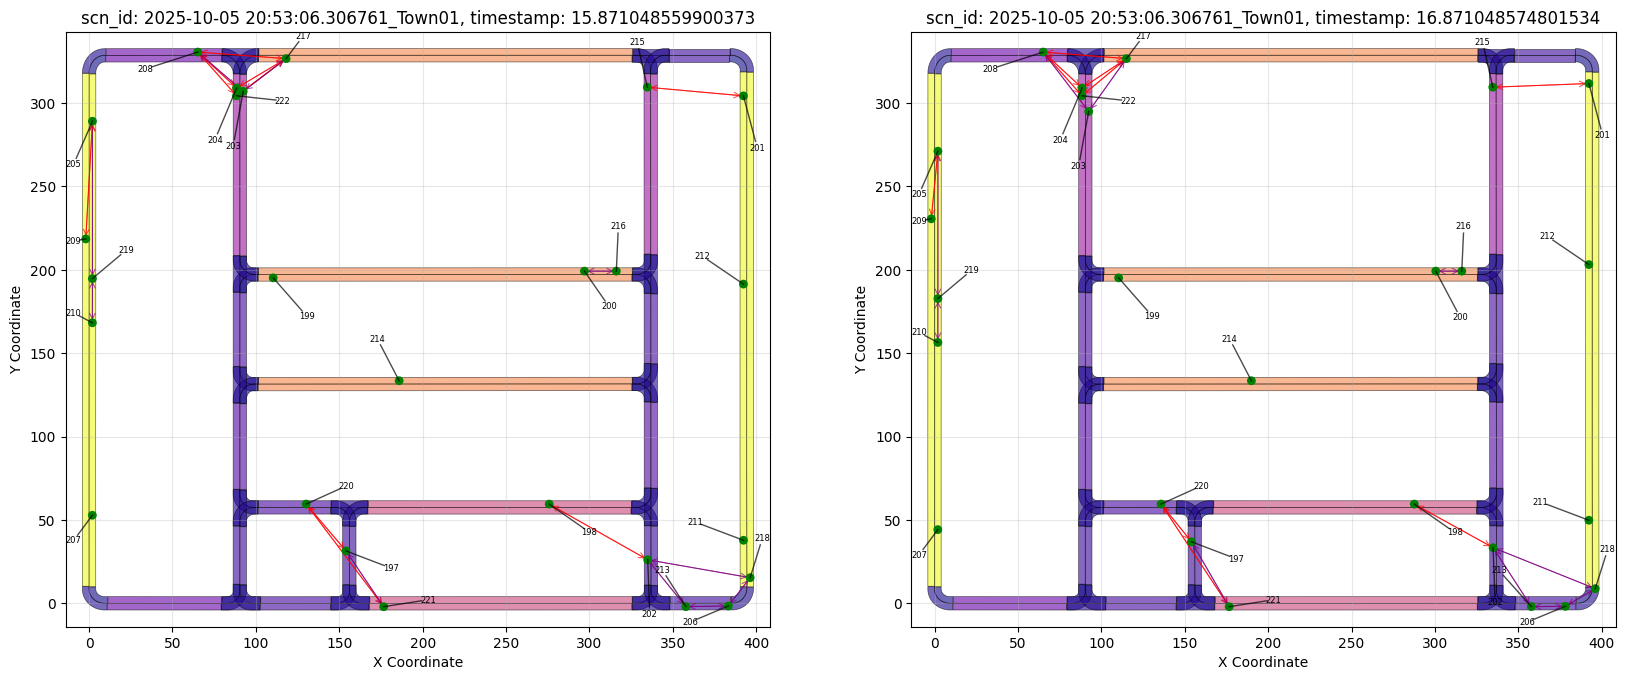

2025-10-05 20:53:41.635057_Town01
count    765.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: distance, dtype: float64


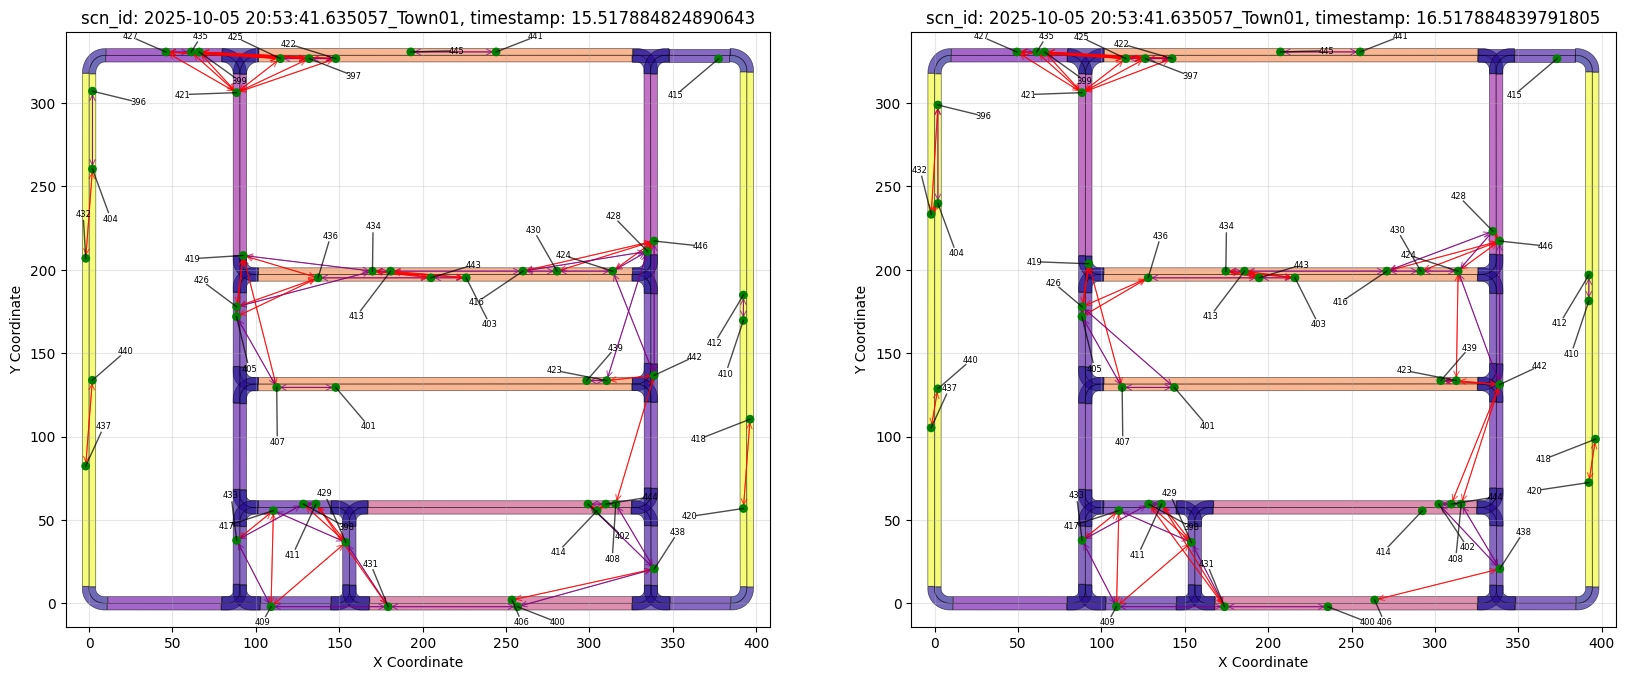

2025-10-05 20:54:34.330511_Town01
count    375.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: distance, dtype: float64


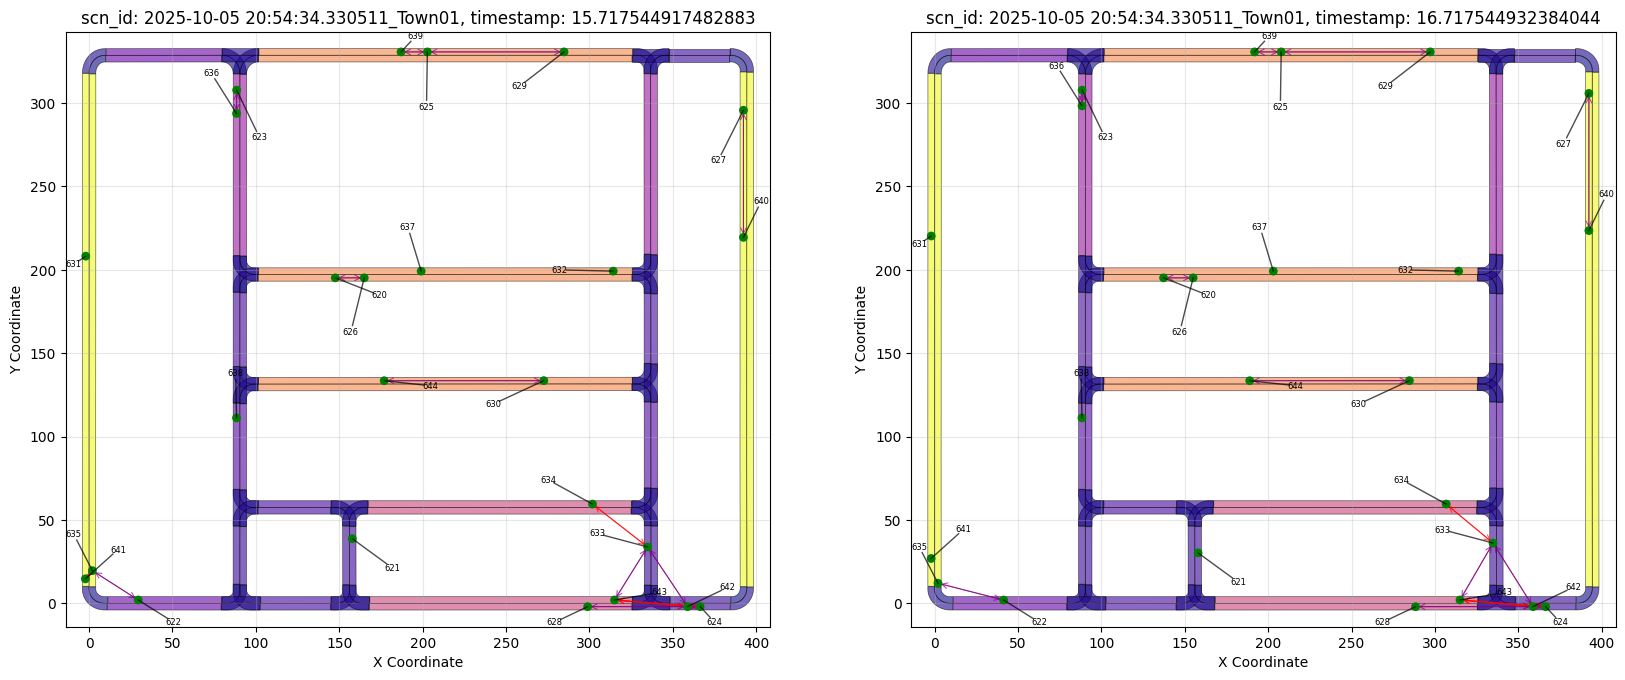

In [12]:
#i = 354
#for i in range(10, 360, 5):
#scn_id = scn_ids[i]

# scn_id = "2025-10-05 15:42:29.792500_Town01"
# scn_id = "2025-10-05 15:46:00.612831_Town01_Opt"
# scn_id = "2025-10-05 15:46:51.769019_Town02_Opt"
#scn_id = "2025-10-05 15:48:10.621007_Town02"
t = 9
# print(scn_id)
for scn_id in scn_ids[:3]:
    tracks = pd.read_parquet(work_dir + f'/example_data/carla/scene_{scn_id}_tracks.parquet')
    tracks['road_lane_id'] = tracks.road_id.astype(str) + '_' + tracks.lane_id.astype(str)
    # print(tracks.shape)
    timestamps = tracks.timestamp.unique().tolist()
    actors = tracks.actor_id.unique().tolist()
    #tracks.head(2).T
    g_map = MapGraph()
    g_map.read_graph_from_file(work_dir + f'/example_data/carla/scene_{scn_id}_map_graph.pickle')
    print(scn_id)
    # #g_map.visualize_graph()
    # fig, ax = plot_lane_map_advanced(g_map.graph, color_by_length=True, cmap='plasma', show_labels=False)
    # plt.show()
    ag = ActorGraph()
    ag_carla = ag.from_carla_scenario(tracks, 
        g_map, 
        delta_timestep_s=1.0,
        max_distance_lead_veh_m=100,
        max_distance_opposite_forward_m=100,
        max_distance_opposite_backward_m=10,
        max_distance_neighbor_forward_m=20,
        max_distance_neighbor_backward_m=20,
        max_node_distance_leading=3,
        max_node_distance_neighbor=2,
        max_node_distance_opposite=2,
        )
    ag_carla.actor_graphs.keys()
    # clean up the graphs and components, i.e. remove components with only one node:
    keys = list(ag_carla.actor_graphs.keys())
    for  key in keys:
        ag_carla.actor_components[key] = [ag_carla.actor_components[key][i] for i in range(len(ag_carla.actor_components[key])) if ag_carla.actor_components[key][i].size() > 1]
    #pd.DataFrame(ag_carla.actor_graphs[5.5085996149573475].nodes(data=True)).iloc[0,1]
    ag_timestamps = list(ag_carla.actor_graphs.keys())
    ag_carla.actor_graphs[ag_timestamps[0]].nodes(data=True)
    ag_carla.actor_graphs[ag_timestamps[0]].edges(data=True)
    # remove offroad actors:
    # Still wait for Marius input, if this is legit of not.
    # @ Thomas I did remove the parking actors. Or what do you mean here by offroad actors?
    offroad_df = check_offroad_actors(ag_carla, g_map)
    print(offroad_df.distance.describe())
    node_df, edge_df = make_node_edge_df(ag_carla.actor_graphs[list(ag_carla.actor_graphs.keys())[1]])
    # node_df.head(2)
    # node_df.actor_type.value_counts()
    ag_carla_time = ActorTimeGraph(ag_carla)
    ag_carla_time.create_actor_time_graphs()
    # clean up the graphs and components, i.e. remove components with only one node:
    keys = list(ag_carla_time.actor_time_graphs.keys())
    for  key in keys:
        ag_carla_time.actor_time_components[key] = [ag_carla_time.actor_time_components[key][i] for i in range(len(ag_carla_time.actor_time_components[key])) if ag_carla_time.actor_time_components[key][i].size() > 1]
    node_time_df, edge_time_df = make_node_edge_df(ag_carla_time.actor_time_graphs[ag_carla_time.timestamps[1]])
    # node_time_df.head(2)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    timestamps = sorted(list(ag_carla.actor_graphs.keys()))
 
    MapVisualizer(fig=fig, ax=ax1) \
        .add_lanes(g_map.graph, color_by_length=True, cmap='plasma', show_labels=False) \
        .add_actors(ag_carla.actor_graphs[timestamps[t]], actor_size=20) \
        .add_actor_labels() \
        .add_actor_edges(ag_carla.actor_graphs[timestamps[t]]) \
        .set_title(f'scn_id: {scn_id}, timestamp: {timestamps[t]}')
    
    MapVisualizer(fig=fig, ax=ax2) \
        .add_lanes(g_map.graph, color_by_length=True, cmap='plasma', show_labels=False) \
        .add_actors(ag_carla.actor_graphs[timestamps[t + 1]], actor_size=20) \
        .add_actor_labels() \
        .add_actor_edges(ag_carla.actor_graphs[timestamps[t + 1]]) \
        .set_title(f'scn_id: {scn_id}, timestamp: {timestamps[t + 1]}')
    
    plt.show()

